In [3]:
import numpy as np
from matplotlib import pyplot
from IPython.display import Markdown

First we define some parameters for our system

In [4]:
# mathematica: {{\[Mu]->0.00331511,\[Lambda]->0.005,\[Rho]->1.}}
lamda = 0.005
kappa = lamda*40
rho = 1.0
mu = 0.00331511
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))
delta = tau_x/50

Markdown(r"""
We define the following parameters

$\langle s \rangle = {}$

$\langle x \rangle = {}$

$\tau_s / \Delta = {}$

$\tau_x / \Delta = {}$

$\rho \Delta = {}$
""".format(mean_s, mean_x, tau_s / delta, tau_x / delta, rho * delta))


We define the following parameters

$\langle s \rangle = 40.0$

$\langle x \rangle = 12065.964628624692$

$\tau_s / \Delta = 20.00000768433904$

$\tau_x / \Delta = 50.0$

$\rho \Delta = 9.999996157831957$


The analytical rate is defined by $R(S,X)=\frac{\lambda}{2}\left[\sqrt{1+\rho/\lambda}-1\right]$

In [5]:
analytical_rate = lambda rho, lamda: lamda/2 * (np.sqrt(1 + rho/lamda) - 1)
Markdown("$R(S,X) = {}$".format(analytical_rate(rho, lamda)))

$R(S,X) = 0.032943617196894565$

In [5]:
def corr_ss(t, rho, mu, lamda, kappa):
    return kappa / lamda * np.exp(-np.abs(t) * lamda)

def corr_xs_pos(t, rho, mu, lamda, kappa):
    return rho * kappa / lamda / (lamda + mu) * np.exp(-lamda * t)

def corr_sx_pos(t, rho, mu, lamda, kappa):
    a = rho * kappa / lamda / (lamda - mu)
    b1 = (1 + (lamda - mu)/(lamda + mu))*np.exp(-mu * t)
    b2 = - np.exp(-lamda * np.abs(t))
    return a * (b1 + b2)

def corr_xs(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_xs_pos(t, rho, mu, lamda, kappa), corr_sx_pos(-t, rho, mu, lamda, kappa))

def corr_sx(t, rho, mu, lamda, kappa):
    return np.where(t >= 0, corr_sx_pos(t, rho, mu, lamda, kappa), corr_xs_pos(-t, rho, mu, lamda, kappa))

def corr_xx(t, rho, mu, lamda, kappa):
    c1 = np.exp(-mu * np.abs(t)) - np.exp(-lamda * np.abs(t))
    c2 = np.exp(-mu * np.abs(t))
    d1 = rho**2 / (lamda**2 - mu**2) * kappa / lamda
    d2 = (1+rho/(lamda+mu)) * kappa / lamda * rho / mu
    return (d1*c1 + d2*c2)

def time_matrix(N, delta_t):
    time_stamps = np.expand_dims(np.linspace(0, (N-1)*delta_t, N), 0)
    return time_stamps - time_stamps.T

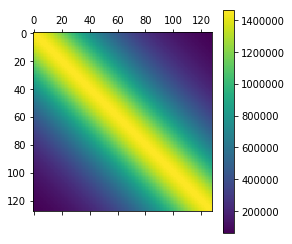

In [6]:
t = time_matrix(128, delta)
c_ss = corr_ss(t, rho, mu, lamda, kappa)
c_sx = corr_sx(t, rho, mu, lamda, kappa)
c_xs = corr_xs(t, rho, mu, lamda, kappa)
c_xx = corr_xx(t, rho, mu, lamda, kappa)
pyplot.matshow(c_xx)
pyplot.colorbar();


In [7]:
def mutual_information_from_matrix(t, rho, mu, lamda, kappa):
    c_ss = corr_ss(t, rho, mu, lamda, kappa)
    c_sx = corr_sx(t, rho, mu, lamda, kappa)
    c_xs = corr_xs(t, rho, mu, lamda, kappa)
    c_xx = corr_xx(t, rho, mu, lamda, kappa)
    
    sign_ss, det_c_ss = np.linalg.slogdet(c_ss)
    sign_xx, det_c_xx = np.linalg.slogdet(c_xx)

    z = np.block([[c_ss, c_xs], [c_sx, c_xx]])
    
    sign_z, det_z = np.linalg.slogdet(z)
    
    assert sign_ss * sign_xx * sign_z == 1, "Sign error: ss: {}, xx: {}, z: {}".format(sign_ss, sign_xx, sign_z)
    
    return 0.5 * (det_c_ss + det_c_xx - det_z)

In [8]:
def mutual_information_(N, delta_t, rho, mu, lamda, kappa):
    t = time_matrix(N, delta_t)
    return mutual_information_from_matrix(t, rho, mu, lamda, kappa)

mutual_information = np.vectorize(mutual_information_)

array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
       2048])

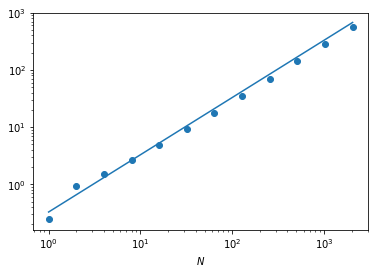

In [9]:
# mathematica: {{\[Mu]->0.00331511,\[Lambda]->0.005,\[Rho]->1.}}
lamda = 0.005
kappa = lamda*40
rho = 1.0
mu = 0.00331511
mean_s = kappa / lamda
mean_x = mean_s * rho / mu
tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))
delta = tau_x/50.0

N = 2**np.arange(0,12)
pyplot.scatter(N, mutual_information(N, delta, rho, mu, lamda, kappa));
pyplot.plot(N, analytical_rate(rho, lamda) * N * delta)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('$N$')
N

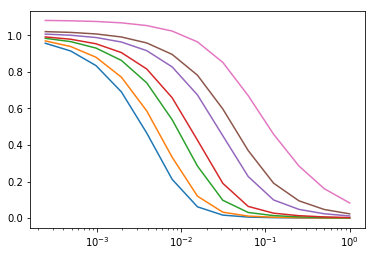

In [10]:
T = 20

N = 2**np.arange(0,13)
delta_arr = T/N

for lamda in [15,10,5,3,1,0.5,0.1]:
    rho = 15
    mu = 1.5
    kappa = lamda
    pyplot.plot(delta_arr / T, mutual_information(N, delta_arr, rho, mu, lamda, kappa) / (T * analytical_rate(rho, lamda)))
pyplot.xscale('log')

In [41]:
analytical_rate(rho, lamda)

0.5644102863722255

(200.0, 83.33333333333334, 0.6103515625)

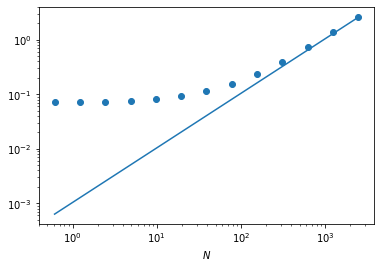

In [82]:
# applied to sim
kappa = 20.0
lamda = 0.005
rho = 0.005
mu = 0.02

tau_s = 1/lamda
tau_x = 1/mu * (1 + rho * mu / (lamda * (lamda + rho + mu)))

N = 2**np.arange(0,13)
T = 2500
delta = T / N[-1]
pyplot.scatter(N * delta, mutual_information(N, delta, rho, mu, lamda, kappa));
pyplot.plot(N * delta, analytical_rate(rho, lamda) * N * delta)
pyplot.xscale('log')
pyplot.yscale('log')
pyplot.xlabel('$N$')

tau_s, tau_x, delta

In [80]:
mutual_information(N, delta, rho, mu, lamda, kappa)

array([0.07155042, 0.07221034, 0.07352942, 0.07616464, 0.08142376,
       0.09190024, 0.1127109 , 0.15391634, 0.23541893, 0.39725253,
       0.72029812, 1.36630923, 2.65833046])

In [84]:
N * delta

array([6.10351562e-01, 1.22070312e+00, 2.44140625e+00, 4.88281250e+00,
       9.76562500e+00, 1.95312500e+01, 3.90625000e+01, 7.81250000e+01,
       1.56250000e+02, 3.12500000e+02, 6.25000000e+02, 1.25000000e+03,
       2.50000000e+03])